In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import libraries and modules

In [2]:
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from objectGenerationRiver_func import*
from DynamicModelCore_River_MPs import*
from GlobalConstants import * 
from readImputParam import readProcessparam, microplasticData,readCompartmentData
import RC_GeneratorRiver
from dilutionVol_calculator_func import*
from Multiplots_function import*


from celluloid import Camera
from cycler import cycler
%matplotlib inline

# Import input files

In [3]:
#####Set current working directory
cwd = os.getcwd()

"""IMPORT INPUT FILES"""
os.chdir(cwd+"/Inputs")
#Import process parameters
process_df= readProcessparam ("process_paramRiver.txt")
#Import MP parameters (radius, volume, etc) Same way
MP_prop = microplasticData("microplasticsSizeClass.txt")
#Import compartment info
compartments_prop = readCompartmentData("compartmentsGenericRiverSec_prop.txt")
#Add river section depth field
RSdepth = []
for row in range(len(compartments_prop)):
        RSdepth.append(round(sum(compartments_prop.depth_m[0:4]),2))
compartments_prop["depthRS_m"]=RSdepth
os.chdir(cwd)

# Model set up

In [4]:
#RIVER SECTIONS
numberRS=len (compartments_prop)/4
listRS = [*range(0,int(numberRS),1)]
riverSect = [str(item) for item in listRS]
riverLengths = [str(it) for it in compartments_prop["length_m"]]
riverSectLength= riverLengths[0::4]
RS_cumLength_m =[]
for d in range(len(riverSectLength)):
    if d==0:
        RS_cumLength_m.append(float(riverSectLength[d]))
    else:
        RS_cumLength_m.append(float(riverSectLength[d])+float(RS_cumLength_m[d-1]))
    
#RIVER COMPARTMENTS
riverComp = ["1", "2", "3", "4"]
compartments = ["Surface Water", "Flowing Water", "Stagnant Water", "Sediment"]

#MICROPLASTICS FORMS 
MPforms = ["A", "B", "C", "D"]
MPformslabels = ["Free", "Heteroaggregated", "Biofiolm-covered", "Biofilm-heteroaggregated"]

#SIZE BINS
sizeBin =["a", "b", "c", "d", "e"]
sizeBinLabel = ["0.1um", "1um","10um", "100um", "1000um"]# Detection limit for MPs via Fourier Transform Infrared Spectroscopy is 20um

#MPS RIVER PROCESSES (FATE AND TRANSPORT) LIST
processList = ["degradation", "fragmentation", "heteroagg", "breakup", "settling","rising", "advection", "mixing", "biofilm", "resusp", "burial","sedTransport"]

# Define run parameters

- Solver (Dynamic). SteadyState under developement
- mode (Standard). Monthly under developement
- mode2 (Timelimit or raw): "Timelimit" mode sets up a time limit of 30min on the processes that exceeds that speed, while "raw" mode leaves the rate constant as calcualted. The raw version can straing the solver due to time.
- record (True or False) : if "True" the results, RC and intercations dataframes will be recorded in the Results folder.

In [5]:
SOLVER = "Dynamic" 
mode = "Standard" 
mode2 = "Timelimit" 
record = "True"

- composition: define MP composition to study (from microplastics imput file, composition: XX, PP, PS, mixed)
- imputMP: Define imput location and MP type: RiverSection, river compartment, MP aggregation state and size bin. Ex: 02Ae (RS=0:1, comp= 2:flowing water, MPtype:A:FreeMP, sizeBin:e:1000um)
- imputFlow: define number of particles per minute entering the system
- imputPulse: define number of particles entering the systems in a pulse (if any)

In [6]:
composition = "PE"
imputMP= "02Ae"
imputFlow=100 
imputPulse=0

- Set simulation time:
    - t0: starting time (min)
    - daysSimulation: total length of simultaion (days)
    - stepSize

In [7]:
t0 = 0 
daysSimulation = 365
tmax = 24*60*daysSimulation 
min_day = 24*60
stepSize= 60
timesteps = int(min_day*daysSimulation/stepSize) 
t_span = np.linspace(0, tmax, int(timesteps)+1, dtype=int)

In [8]:
#############
from datetime import datetime, timedelta
date_time_str = '2020-01-01 00:00'
DayStart = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
LastDay = DayStart + timedelta(minutes=tmax)
date = DayStart

daterun = date.today()
daterun_label = daterun.strftime("%d_%m_%Y")
##############

# Define model run results file name

In [10]:
runtitle= "GenericRiver_" + composition +"_runtime"+str(daysSimulation)+"_ts"+str(stepSize)+"min_Imput_"+ imputMP + "_abcde_"+mode2+"_TestRun"
runtitle

'GenericRiver_PE_runtime365_ts60min_Imput_02Ae_abcde_Timelimit_TestRun'

# Run model

In [11]:
"""COMBINATIONS LIST"""

#Generate COMBINATIONS
combinations = list(itertools.product(riverSect,riverComp,MPforms,sizeBin))
#Generate raw list of combinations and lists of concentrations (C) and inflows (I)
CombList = []
Ilist = []
Clist =[]
def convertTuple(tup): 
    str =  ''.join(tup) 
    return str
for e in combinations:
    Clist.append("C_" + convertTuple(e))
    Ilist.append("I_" + convertTuple(e))
    CombList.append(convertTuple(e))

## -Estimate Rate constants

In [12]:
 """Estimate RATE CONSTANTS"""
##Estimate rate constants for all "species" = combination of RS*riverComp*MPforms*sizeBins (len (Clist))

RC_df = pd.DataFrame(index=processList , columns= CombList)
extraRow = pd.DataFrame(index= ["volume_m3","density_kg_m3"] , columns= CombList)
RC_df=pd.concat([RC_df,extraRow])

if numberRS <= 10:
    print("Less than 10 RS")
#if len(Clist) <= 10*len(riverComp)*len(MPforms)*len(sizeBin):
    for spc in Clist:
       
        riverSection = spc[2]
        compartment= spc[3]
        aggState = spc[4]
        sizeBinIdx = spc[5]
    
        #Generate particle OBJECTS MPs and SPM for the corresponding size bin
        
        #generate location index from imput tables
        MP_index = np.where((MP_prop['composition']== composition) & (MP_prop['sizeBin']== sizeBinIdx))[0][0]
        SPM_index = np.where((MP_prop['name']== "SPM1") & (MP_prop['sizeBin']== sizeBinIdx))[0][0]
        comp_index = np.where((compartments_prop['compartment']== int(compartment)) & (compartments_prop['riverSection']== int(riverSection)))[0][0]
        
        
        [MP1,SPM1,MP1_SPM,MP1_BF,MP1_BF_SPM]=preProcessElements(MP_prop, MP_index, SPM_index, compartments_prop, comp_index)#add compartments_prop, comp_index to include corresponding SPM concentration
    
        #Create a dictionary with the objects 
        particles_dict = {"A": MP1, "B": MP1_SPM, "C": MP1_BF, "D": MP1_BF_SPM }
          
        #load compartment objects corresponding to the River Section
        
        [surface, flowingWater, stagnantWater, sediment]= preProcessLayers(mode, compartments_prop, date, comp_index)
        #Create a dictionary with the environmental compartments objects 
        comp_dict = {"1": surface, "2": flowingWater, "3": stagnantWater, "4": sediment }
        
        #import data needed for each spcn(t_half, radius...)
        #for processes
        idx = np.where((process_df['aggState']==aggState) & (process_df['compartment']== int(compartment)))[0][0]
        
    
        RC_df.loc["degradation", spc[2:6]]= RC_GeneratorRiver.degradation(process_df.t_half_d.loc[idx]) 
        RC_df.loc["fragmentation", spc[2:6]]= RC_GeneratorRiver.fragmentation(process_df.k_frag_d.loc[idx], particles_dict[aggState].radius_m,  particles_dict[aggState].volume_m3,  particles_dict[aggState].diameter_um, sizeBinIdx)
        RC_df.loc["heteroagg", spc[2:6]]= RC_GeneratorRiver.heteroagg(process_df.alpha.loc[idx], MP1.radius_m, SPM1.radius_m, MP1.density_kg_m3, SPM1.density_kg_m3, SPM1.concNum_part_m3, compartments_prop.G.loc[comp_index], compartments_prop.T_K.loc[comp_index], compartment)
        RC_df.loc["breakup", spc[2:6]]= RC_GeneratorRiver.breakup(process_df, idx, MP1.radius_m, SPM1.radius_m, MP1.density_kg_m3, SPM1.density_kg_m3, SPM1.concNum_part_m3,compartments_prop.G.loc[comp_index], compartments_prop.T_K.loc[comp_index], compartment, aggState)
        RC_df.loc["settling", spc[2:6]]= RC_GeneratorRiver.settling(particles_dict["A"].density_kg_m3, particles_dict[aggState].radius_m, surface.depth_m, "Stokes", compartment)
        RC_df.loc["rising", spc[2:6]]= RC_GeneratorRiver.rising(particles_dict[aggState].density_kg_m3, particles_dict[aggState].radius_m, flowingWater.depth_m, "Stokes", compartment)
        RC_df.loc["advection", spc[2:6]]= RC_GeneratorRiver.advection(comp_dict, compartment)
        RC_df.loc["mixing", spc[2:6]]= RC_GeneratorRiver.mixing(flowingWater,compartment, "up", comp_dict) #update creteria for mixing direction
        RC_df.loc["biofilm", spc[2:6]]= RC_GeneratorRiver.biofilm(compartment, process_df, comp_dict, idx, aggState)#add t biofilm growth?? Look at new processess MPLake-Antonia
        RC_df.loc["resusp", spc[2:6]]= RC_GeneratorRiver.resusp(compartment, comp_dict)
        RC_df.loc["burial", spc[2:6]]= RC_GeneratorRiver.burial(compartment, comp_dict)
        RC_df.loc["sedTransport", spc[2:6]]= RC_GeneratorRiver.sedTransport(compartment,comp_dict)
        RC_df.loc["volume_m3", spc[2:6]]= particles_dict[aggState].volume_m3
        RC_df.loc["density_kg_m3", spc[2:6]]= particles_dict[aggState].density_kg_m3

elif numberRS <= 100:
    print("10 or more RS but less than 100")
    for spc in Clist:
        if spc in Clist[0:10*len(riverComp)*len(MPforms)*len(sizeBin)]:
            riverSection = spc[2]
            compartment= spc[3]
            aggState = spc[4]
            sizeBinIdx = spc[5]
            #spcAll=spc[2:6]
        elif spc in Clist[10*len(riverComp)*len(MPforms)*len(sizeBin):100*len(riverComp)*len(MPforms)*len(sizeBin)]:
        #else:
            riverSection = spc[2:4]
            compartment= spc[4]
            aggState = spc[5]
            sizeBinIdx = spc[6]
            #spcAll=spc[2:7]
        #Generate particle OBJECTS MPs and SPM for the corresponding size bin
        
        #generate location index from imput tables
        MP_index = np.where((MP_prop['composition']== composition) & (MP_prop['sizeBin']== sizeBinIdx))[0][0]
        SPM_index = np.where((MP_prop['name']== "SPM1") & (MP_prop['sizeBin']== sizeBinIdx))[0][0]
        comp_index = np.where((compartments_prop['compartment']== int(compartment)) & (compartments_prop['riverSection']== int(riverSection)))[0][0]
        
        
        [MP1,SPM1,MP1_SPM,MP1_BF,MP1_BF_SPM]=preProcessElements(MP_prop, MP_index, SPM_index, compartments_prop, comp_index)#add compartments_prop, comp_index to include corresponding SPM concentration
    
        #Create a dictionary with the objects 
        particles_dict = {"A": MP1, "B": MP1_SPM, "C": MP1_BF, "D": MP1_BF_SPM }
          
        #load compartment objects corresponding to the River Section
        
        [surface, flowingWater, stagnantWater, sediment]= preProcessLayers(mode, compartments_prop, date, comp_index)
        #Create a dictionary with the environmental compartments objects 
        comp_dict = {"1": surface, "2": flowingWater, "3": stagnantWater, "4": sediment }
        
        #import data needed for each spcn(t_half, radius...)
        #for processes
        idx = np.where((process_df['aggState']==aggState) & (process_df['compartment']== int(compartment)))[0][0]
        
    
        RC_df.loc["degradation", spc[2:]]= RC_GeneratorRiver.degradation(process_df.t_half_d.loc[idx]) 
        RC_df.loc["fragmentation", spc[2:]]= RC_GeneratorRiver.fragmentation(process_df.k_frag_d.loc[idx], particles_dict[aggState].radius_m,  particles_dict[aggState].volume_m3,  particles_dict[aggState].diameter_um, sizeBinIdx)
        RC_df.loc["heteroagg", spc[2:]]= RC_GeneratorRiver.heteroagg(process_df.alpha.loc[idx], MP1.radius_m, SPM1.radius_m, MP1.density_kg_m3, SPM1.density_kg_m3, SPM1.concNum_part_m3, compartments_prop.G.loc[comp_index], compartments_prop.T_K.loc[comp_index], compartment)
        RC_df.loc["breakup", spc[2:]]= RC_GeneratorRiver.breakup(process_df, idx, MP1.radius_m, SPM1.radius_m, MP1.density_kg_m3, SPM1.density_kg_m3, SPM1.concNum_part_m3,compartments_prop.G.loc[comp_index], compartments_prop.T_K.loc[comp_index], compartment, aggState)
        RC_df.loc["settling", spc[2:]]= RC_GeneratorRiver.settling(particles_dict["A"].density_kg_m3, particles_dict[aggState].radius_m, surface.depth_m, "Stokes", compartment)
        RC_df.loc["rising", spc[2:]]= RC_GeneratorRiver.rising(particles_dict[aggState].density_kg_m3, particles_dict[aggState].radius_m, flowingWater.depth_m, "Stokes", compartment)
        RC_df.loc["advection", spc[2:]]= RC_GeneratorRiver.advection(comp_dict, compartment)
        RC_df.loc["mixing", spc[2:]]= RC_GeneratorRiver.mixing(flowingWater,compartment, "up", comp_dict) #update creteria for mixing direction
        RC_df.loc["biofilm", spc[2:]]= RC_GeneratorRiver.biofilm(compartment, process_df, comp_dict, idx, aggState)#add t biofilm growth?? Look at new processess MPLake-Antonia
        RC_df.loc["resusp", spc[2:]]= RC_GeneratorRiver.resusp(compartment, comp_dict)
        RC_df.loc["burial", spc[2:]]= RC_GeneratorRiver.burial(compartment, comp_dict)
        RC_df.loc["sedTransport", spc[2:]]= RC_GeneratorRiver.sedTransport(compartment,comp_dict)
        RC_df.loc["volume_m3", spc[2:]]= particles_dict[aggState].volume_m3
        RC_df.loc["density_kg_m3", spc[2:]]= particles_dict[aggState].density_kg_m3
        
elif numberRS <= 1000:
    print("100 or more RS but less than 1000")
    for spc in Clist:
        if spc in Clist[0:10*len(riverComp)*len(MPforms)*len(sizeBin)]:
            riverSection = spc[2]
            compartment= spc[3]
            aggState = spc[4]
            sizeBinIdx = spc[5]
        elif spc in Clist[10*len(riverComp)*len(MPforms)*len(sizeBin):100*len(riverComp)*len(MPforms)*len(sizeBin)]:
            riverSection = spc[2:4]
            compartment= spc[4]
            aggState = spc[5]
            sizeBinIdx = spc[6]
        elif spc in Clist[100*len(riverComp)*len(MPforms)*len(sizeBin):1000*len(riverComp)*len(MPforms)*len(sizeBin)]:
            riverSection = spc[2:5]
            compartment= spc[5]
            aggState = spc[6]
            sizeBinIdx = spc[7]
        #Generate particle OBJECTS MPs and SPM for the corresponding size bin
        
        #generate location index from imput tables
        MP_index = np.where((MP_prop['composition']== composition) & (MP_prop['sizeBin']== sizeBinIdx))[0][0]
        SPM_index = np.where((MP_prop['name']== "SPM1") & (MP_prop['sizeBin']== sizeBinIdx))[0][0]
        comp_index = np.where((compartments_prop['compartment']== int(compartment)) & (compartments_prop['riverSection']== int(riverSection)))[0][0]
        
        
        [MP1,SPM1,MP1_SPM,MP1_BF,MP1_BF_SPM]=preProcessElements(MP_prop, MP_index, SPM_index, compartments_prop, comp_index)#add compartments_prop, comp_index to include corresponding SPM concentration
    
        #Create a dictionary with the objects 
        particles_dict = {"A": MP1, "B": MP1_SPM, "C": MP1_BF, "D": MP1_BF_SPM }
          
        #load compartment objects corresponding to the River Section
        
        [surface, flowingWater, stagnantWater, sediment]= preProcessLayers(mode, compartments_prop, date, comp_index)
        #Create a dictionary with the environmental compartments objects 
        comp_dict = {"1": surface, "2": flowingWater, "3": stagnantWater, "4": sediment }
        
        #import data needed for each spcn(t_half, radius...)
        #for processes
        idx = np.where((process_df['aggState']==aggState) & (process_df['compartment']== int(compartment)))[0][0]
        
    
        RC_df.loc["degradation", spc[2:]]= RC_GeneratorRiver.degradation(process_df.t_half_d.loc[idx]) 
        RC_df.loc["fragmentation", spc[2:]]= RC_GeneratorRiver.fragmentation(process_df.k_frag_d.loc[idx], particles_dict[aggState].radius_m,  particles_dict[aggState].volume_m3,  particles_dict[aggState].diameter_um, sizeBinIdx)
        RC_df.loc["heteroagg", spc[2:]]= RC_GeneratorRiver.heteroagg(process_df.alpha.loc[idx], MP1.radius_m, SPM1.radius_m, MP1.density_kg_m3, SPM1.density_kg_m3, SPM1.concNum_part_m3, compartments_prop.G.loc[comp_index], compartments_prop.T_K.loc[comp_index], compartment)
        RC_df.loc["breakup", spc[2:]]= RC_GeneratorRiver.breakup(process_df, idx, MP1.radius_m, SPM1.radius_m, MP1.density_kg_m3, SPM1.density_kg_m3, SPM1.concNum_part_m3,compartments_prop.G.loc[comp_index], compartments_prop.T_K.loc[comp_index], compartment, aggState)
        RC_df.loc["settling", spc[2:]]= RC_GeneratorRiver.settling(particles_dict["A"].density_kg_m3, particles_dict[aggState].radius_m, surface.depth_m, "Stokes", compartment)
        RC_df.loc["rising", spc[2:]]= RC_GeneratorRiver.rising(particles_dict[aggState].density_kg_m3, particles_dict[aggState].radius_m, flowingWater.depth_m, "Stokes", compartment)
        RC_df.loc["advection", spc[2:]]= RC_GeneratorRiver.advection(comp_dict, compartment,compartments_prop.discharge_m3s[comp_index])
        RC_df.loc["mixing", spc[2:]]= RC_GeneratorRiver.mixing(flowingWater,compartment, "up", comp_dict) #update creteria for mixing direction
        RC_df.loc["biofilm", spc[2:]]= RC_GeneratorRiver.biofilm(compartment, process_df, comp_dict, idx, aggState)#add t biofilm growth?? Look at new processess MPLake-Antonia
        RC_df.loc["resusp", spc[2:]]= RC_GeneratorRiver.resusp(compartment, comp_dict)
        RC_df.loc["burial", spc[2:]]= RC_GeneratorRiver.burial(compartment, comp_dict)
        RC_df.loc["sedTransport", spc[2:]]= RC_GeneratorRiver.sedTransport(compartment,comp_dict)
        RC_df.loc["volume_m3", spc[2:]]= particles_dict[aggState].volume_m3
        RC_df.loc["density_kg_m3", spc[2:]]= particles_dict[aggState].density_kg_m3
else:
    print("Number of river sections excedes 1000. Implement new code for RCs")    
#substitute NAN values by 0 in Rate cosntants dataframe 
for x in RC_df:
    RC_df[x] = RC_df[x].fillna(0)
    
#SPEED PROCESS CONTROL
#To speed up the solver eliminate those RC for wich proccesses are faster than 30min (1800sec)--> RC<5.56x10-4
if mode2 == "Timelimit":
    RC_df_templim=pd.DataFrame(index=processList , columns= CombList)
    #Add a row to store values of volume of the particles and its density
    extraRow = pd.DataFrame(index= ["volume_m3","density_kg_m3"] , columns= CombList)
    RC_df_templim=pd.concat([RC_df_templim,extraRow])
    for x in RC_df:
        for y in range(len(RC_df)-2):   
            if type(RC_df[x][y]) is tuple:
                # when there are fragements formed extract the fragmentation array to multiply kfrag by number of fragments formed
                frag = RC_df[x][y]
                fragRC = frag[0]
                if (fragRC !=0) and (fragRC > 0.000556):
                    #print(RC_df.index[y]+" RC for " +x+ " is fastest than 30min")
                    fragRC=0.000556
                    RC_df_templim[x][y]=(fragRC,frag[1])
                else:
                    RC_df_templim[x][y]=RC_df[x][y]
            else:   
                if (RC_df[x][y]!=0) and (RC_df[x][y] > 0.000556):
                    #print(RC_df.index[y]+" RC for " +x+ " is fastest than 30min")
                    RC_df_templim[x][y]=0.000556
                else:
                    #print(RC_df[x][y])
                    RC_df_templim[x][y]=RC_df[x][y]
        for y in range(len(RC_df)-2,len(RC_df)):
            RC_df_templim[x][y]= RC_df[x][y]
    for x in RC_df_templim:
        if (RC_df_templim.loc["breakup",[x]][0] == 0.000556):
            RC_df_templim.loc["breakup",[x]] = 0.000556/10

10 or more RS but less than 100


### Rate constants dataframe 

In [13]:
RC_df_templim

,01Aa,01Ab,01Ac,01Ad,01Ae,01Ba,01Bb,01Bc,01Bd,01Be,...,194Ca,194Cb,194Cc,194Cd,194Ce,194Da,194Db,194Dc,194Dd,194De
degradation,1.60451e-09,1.60451e-09,1.60451e-09,1.60451e-09,1.60451e-09,1.60451e-10,1.60451e-10,1.60451e-10,1.60451e-10,1.60451e-10,...,3.20901e-10,3.20901e-10,3.20901e-10,3.20901e-10,3.20901e-10,8.02254e-11,8.02254e-11,8.02254e-11,8.02254e-11,8.02254e-11
fragmentation,3.1713e-11,"(3.171296296296297e-10, 1000.0)","(3.171296296296297e-09, 999.9999999999997)","(3.171296296296296e-08, 1000.0000000000001)","(3.1712962962962967e-07, 1000.0)",0,"(0.0, 999.9999999999975)","(0.0, 999.9999999999978)","(0.0, 999.9999999999981)","(0.0, 999.9999999999987)",...,1.6015e-10,"(1.744212962962963e-10, 1000.0000000000002)","(3.1712962962962965e-10, 999.9999999999997)","(1.7442129629629627e-09, 999.9999999999998)","(1.6015046296296294e-08, 1000.0)",0,"(0.0, 999.9999999999978)","(0.0, 999.9999999999983)","(0.0, 999.9999999999984)","(0.0, 999.9999999999987)"
heteroagg,4.55619e-05,4.14024e-05,0.000556,0.000556,0.000556,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
breakup,0,0,0,0,0,4.55619e-06,4.14024e-06,0.000478566,5.56e-05,5.56e-05,...,0,0,0,0,0,0,0,0,0,0
settling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rising,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advection,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,...,0,0,0,0,0,0,0,0,0,0
mixing,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,...,0,0,0,0,0,0,0,0,0,0
biofilm,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,...,0,0,0,0,0,0,0,0,0,0
resusp,0,0,0,0,0,0,0,0,0,0,...,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05


## -Generate Interactions Matrix

In [14]:
#Timer for Interactions matrix
#startTime = datetime.now()
"""FILL MATRIX OF INTERACTIONS""" 
#Fill in interactions matrix with process rate constants
from fillRCmatrixInteractionsTransport_func import*
from fillRCinteractionMatrices_func import*


if mode2 == "Timelimit":
    interactions_df = fillMatrixInteractionsALL(RC_df_templim, Clist,compartments_prop)
    Interaction_dataframes= fillMatricesOfInteractions(RC_df_templim, Clist,compartments_prop)
    klosses_df= fillMatricesOfIrrevLoss(RC_df_templim, Clist,compartments_prop) 
    
else:
    interactions_df = fillMatrixInteractionsALL(RC_df, Clist,compartments_prop)
    Interaction_dataframes= fillMatricesOfInteractions(RC_df, Clist,compartments_prop)
    klosses_df= fillMatricesOfIrrevLoss(RC_df, Clist,compartments_prop)


#print(" Time until generation of interactions_matrix " + datetime.now() - startTime)

### Interactions dataframe

In [15]:
interactions_df

,01Aa,01Ab,01Ac,01Ad,01Ae,01Ba,01Bb,01Bc,01Bd,01Be,...,194Ca,194Cb,194Cc,194Cd,194Ce,194Da,194Db,194Dc,194Dd,194De
01Aa,-7.272192e-05,0.000000,0.000000,0.000000,0.000000,0.000046,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ab,3.171296e-07,-0.000069,0.000000,0.000000,0.000000,0.000000,0.000041,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ac,0.000000e+00,0.000003,-0.000583,0.000000,0.000000,0.000000,0.000000,0.000556,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ad,0.000000e+00,0.000000,0.000032,-0.000583,0.000000,0.000000,0.000000,0.000000,0.000556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ae,0.000000e+00,0.000000,0.000000,0.000317,-0.000583,0.000000,0.000000,0.000000,0.000000,0.000556,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194Da,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,-0.00004,0.00000,0.00000,0.00000,0.00000
194Db,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,-0.00004,0.00000,0.00000,0.00000
194Dc,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,-0.00004,0.00000,0.00000
194Dd,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,-0.00004,0.00000


## -SOLVER

In [16]:
#Vector of volumes corresponding to the compartments of the river
dilution_vol_m3= volumesVector(Clist,compartments_prop)

#Dataframes for storing starting and final concentrations for all possible species of each size class
  
Concentrations_t0 = pd.DataFrame(index=Clist, columns=['number (#/m3)'])
for p in range(len(Concentrations_t0)):
        Concentrations_t0.iloc[p][0]= 0
Concentrations_t0.loc["C_"+imputMP]=imputPulse
for p in range(len(Concentrations_t0)):
        Concentrations_t0.iloc[p][0]= Concentrations_t0.iloc[p][0]/dilution_vol_m3[p]

#set inflow 
Ilist = []
for C in Clist:
    Ilist.append("I"+ C[1:])
inflow_vector = pd.DataFrame(index=Ilist, columns=["number (#/m3)"])
inflow_vector.loc[:,:] = 0
inflow_vector.loc["I_"+imputMP] = imputFlow# to be read in from emission files
for q in range(len(inflow_vector)):
        inflow_vector.iloc[q][0]= inflow_vector.iloc[q][0]/dilution_vol_m3[q]


#solve model in steady state mode
if SOLVER == "SteadyState":
    q=50 #MPs released to MainWater per second
    SteadyStateResults = SteadyState(MainWater, SurfWater, Sediment, q)#to be implemented (OLD VERSION)
    
    #solve model dynamically
elif SOLVER == "Dynamic":
    
   DynamicResults = solverPrado(Concentrations_t0, interactions_df,inflow_vector, tmax, timesteps, t_span)
   
   ConcFinal_num_m3=DynamicResults[0]
   
   #Substitute values smaller than 10-5 to 0
   ConcFinal_num_m3 = ConcFinal_num_m3.apply(lambda x: [y if y >= 1e-15 else 0 for y in x])
  
   ###Convert particle number to mass concentration
   ConcFinal_kg_m3= pd.DataFrame(index=t_span , columns= Concentrations_t0.index)  
   volume= RC_df.loc["volume_m3"].to_numpy()
   density= RC_df.loc["density_kg_m3"].to_numpy()
   for row in ConcFinal_num_m3.index:
        ConcFinal_kg_m3.loc[row, :]= ConcFinal_num_m3.loc[row, :]*volume*density

else:
    print("Error: incorrect solver selected")

### Concentrations dataframe (particle number/m3)

In [17]:
ConcFinal_num_m3

,C_01Aa,C_01Ab,C_01Ac,C_01Ad,C_01Ae,C_01Ba,C_01Bb,C_01Bc,C_01Bd,C_01Be,...,C_194Ca,C_194Cb,C_194Cc,C_194Cd,C_194Ce,C_194Da,C_194Db,C_194Dc,C_194Dd,C_194De
0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
60,0.000000,0.000000e+00,1.873055e-11,3.320712e-08,0.000005,0.000000,0.000000,1.362393e-13,3.317568e-10,1.169926e-07,...,0,0,0,0,0,0,0,0,0,0
120,0.000000,2.131003e-14,2.439151e-10,2.410842e-07,0.000019,0.000000,0.000000,3.701099e-12,4.350758e-09,8.550887e-07,...,0,0,0,0,0,0,0,0,0,0
180,0.000000,1.428831e-13,1.147565e-09,7.894687e-07,0.000042,0.000000,0.000000,2.471137e-11,2.058463e-08,2.818743e-06,...,0,0,0,0,0,0,0,0,0,0
240,0.000000,5.611021e-13,3.468816e-09,1.811298e-06,0.000071,0.000000,0.000000,9.660006e-11,6.256766e-08,6.512055e-06,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525360,0.000004,8.975666e-04,1.785572e-02,3.127822e-02,0.020120,0.000006,0.001188,1.968567e-02,2.131384e-01,1.643306e-01,...,0,0,0,0,0,0,0,0,0,0
525420,0.000004,8.975668e-04,1.785572e-02,3.127822e-02,0.020120,0.000006,0.001188,1.968567e-02,2.131384e-01,1.643306e-01,...,0,0,0,0,0,0,0,0,0,0
525480,0.000004,8.975670e-04,1.785572e-02,3.127822e-02,0.020120,0.000006,0.001188,1.968568e-02,2.131384e-01,1.643306e-01,...,0,0,0,0,0,0,0,0,0,0
525540,0.000004,8.975671e-04,1.785573e-02,3.127822e-02,0.020120,0.000006,0.001188,1.968568e-02,2.131384e-01,1.643306e-01,...,0,0,0,0,0,0,0,0,0,0


### Concentrations dataframe (Kg/m3)

In [18]:
ConcFinal_kg_m3

,C_01Aa,C_01Ab,C_01Ac,C_01Ad,C_01Ae,C_01Ba,C_01Bb,C_01Bc,C_01Bd,C_01Be,...,C_194Ca,C_194Cb,C_194Cc,C_194Cd,C_194Ce,C_194Da,C_194Db,C_194Dc,C_194Dd,C_194De
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,9.61115e-24,1.70395e-17,2.5264e-12,0,0,6.99258e-26,1.70233e-19,6.0032e-14,...,0,0,0,0,0,0,0,0,0,0
120,0,1.09347e-29,1.25159e-22,1.23707e-16,9.79123e-12,0,0,1.89962e-24,2.23249e-18,4.38769e-13,...,0,0,0,0,0,0,0,0,0,0
180,0,7.33171e-29,5.88846e-22,4.05098e-16,2.12949e-11,0,0,1.26833e-23,1.05625e-17,1.44637e-12,...,0,0,0,0,0,0,0,0,0,0
240,0,2.87917e-28,1.77994e-21,9.29426e-16,3.66056e-11,0,0,4.95807e-23,3.21052e-17,3.34151e-12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525360,2.20706e-24,4.60565e-19,9.16225e-15,1.60497e-11,1.0324e-08,8.12713e-22,7.64868e-19,1.01038e-14,1.09367e-10,8.43225e-08,...,0,0,0,0,0,0,0,0,0,0
525420,2.20706e-24,4.60566e-19,9.16225e-15,1.60497e-11,1.0324e-08,8.12714e-22,7.64868e-19,1.01038e-14,1.09367e-10,8.43225e-08,...,0,0,0,0,0,0,0,0,0,0
525480,2.20707e-24,4.60566e-19,9.16225e-15,1.60497e-11,1.0324e-08,8.12715e-22,7.64869e-19,1.01038e-14,1.09367e-10,8.43225e-08,...,0,0,0,0,0,0,0,0,0,0
525540,2.20707e-24,4.60566e-19,9.16225e-15,1.60497e-11,1.0324e-08,8.12716e-22,7.64869e-19,1.01038e-14,1.09367e-10,8.43225e-08,...,0,0,0,0,0,0,0,0,0,0


# Plot results

## Multyplots graphs: Concentration over time

### Select time span units

In [19]:
t_span_min = np.linspace(t0, tmax, int(timesteps)+1, dtype=int)
t_span_h = t_span_min/60
t_span_days = t_span_h/24

In [20]:
t_span_plot =t_span_days

### Select river sections to plot

In [21]:
RS= ["0","3","5","9","10","12","19"] 

### Select color palette and style

In [22]:
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-white')

### Plot

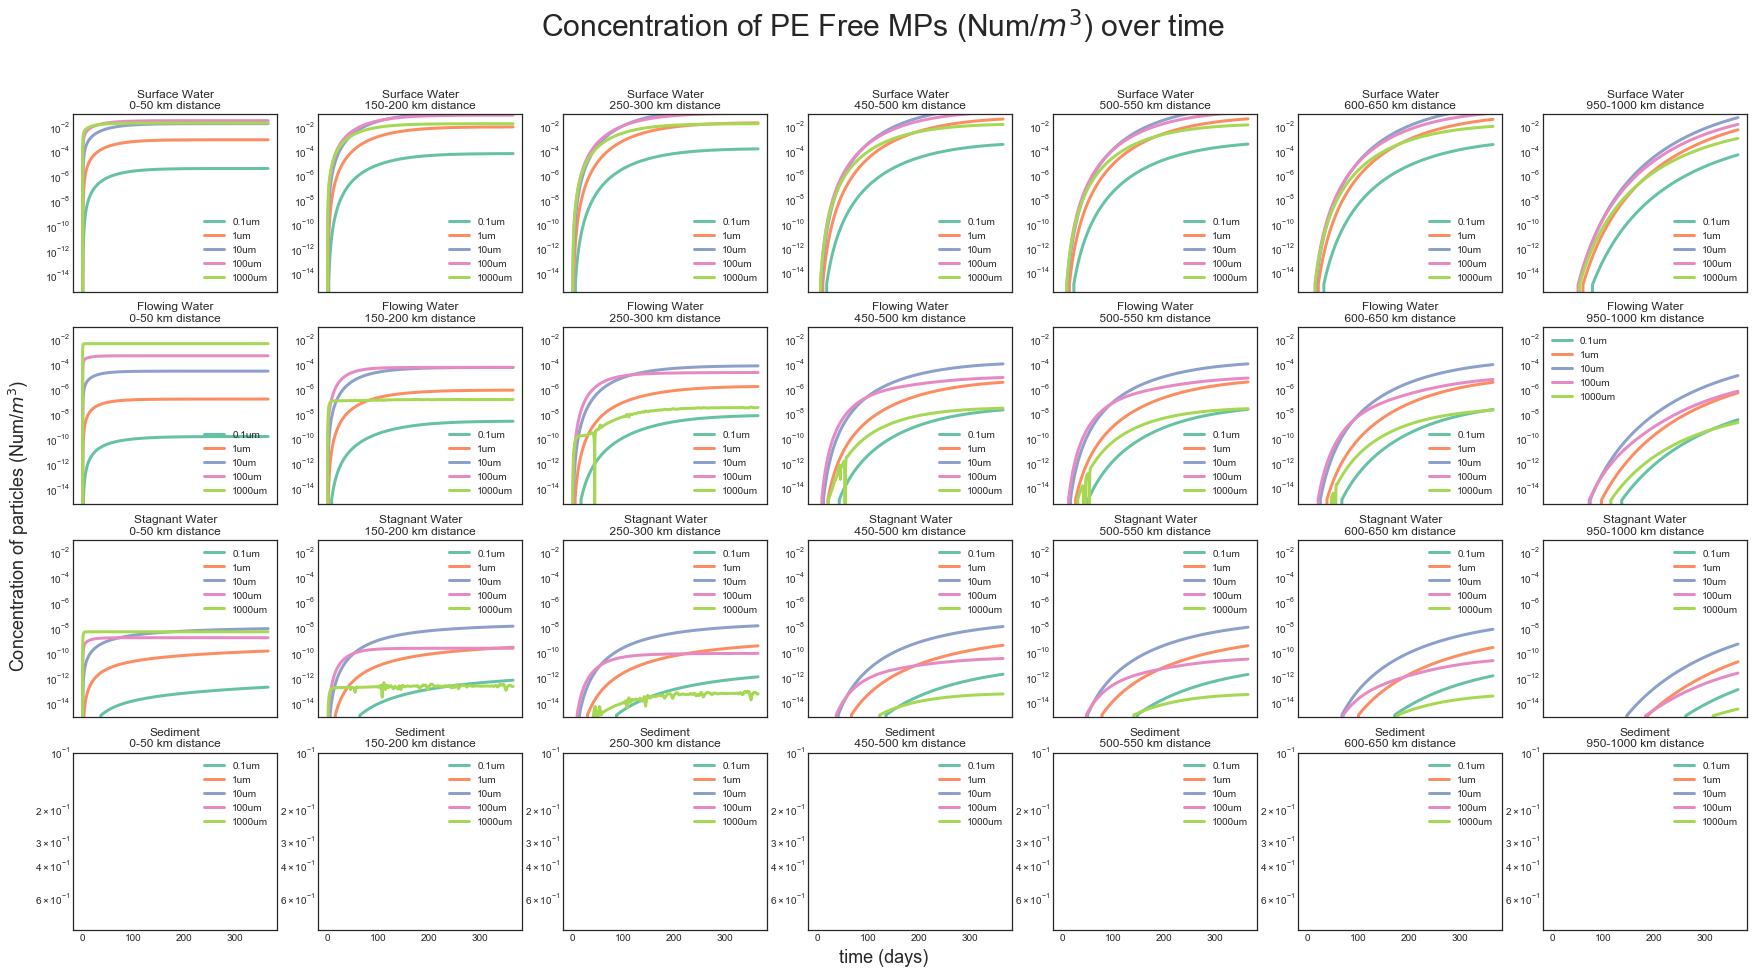

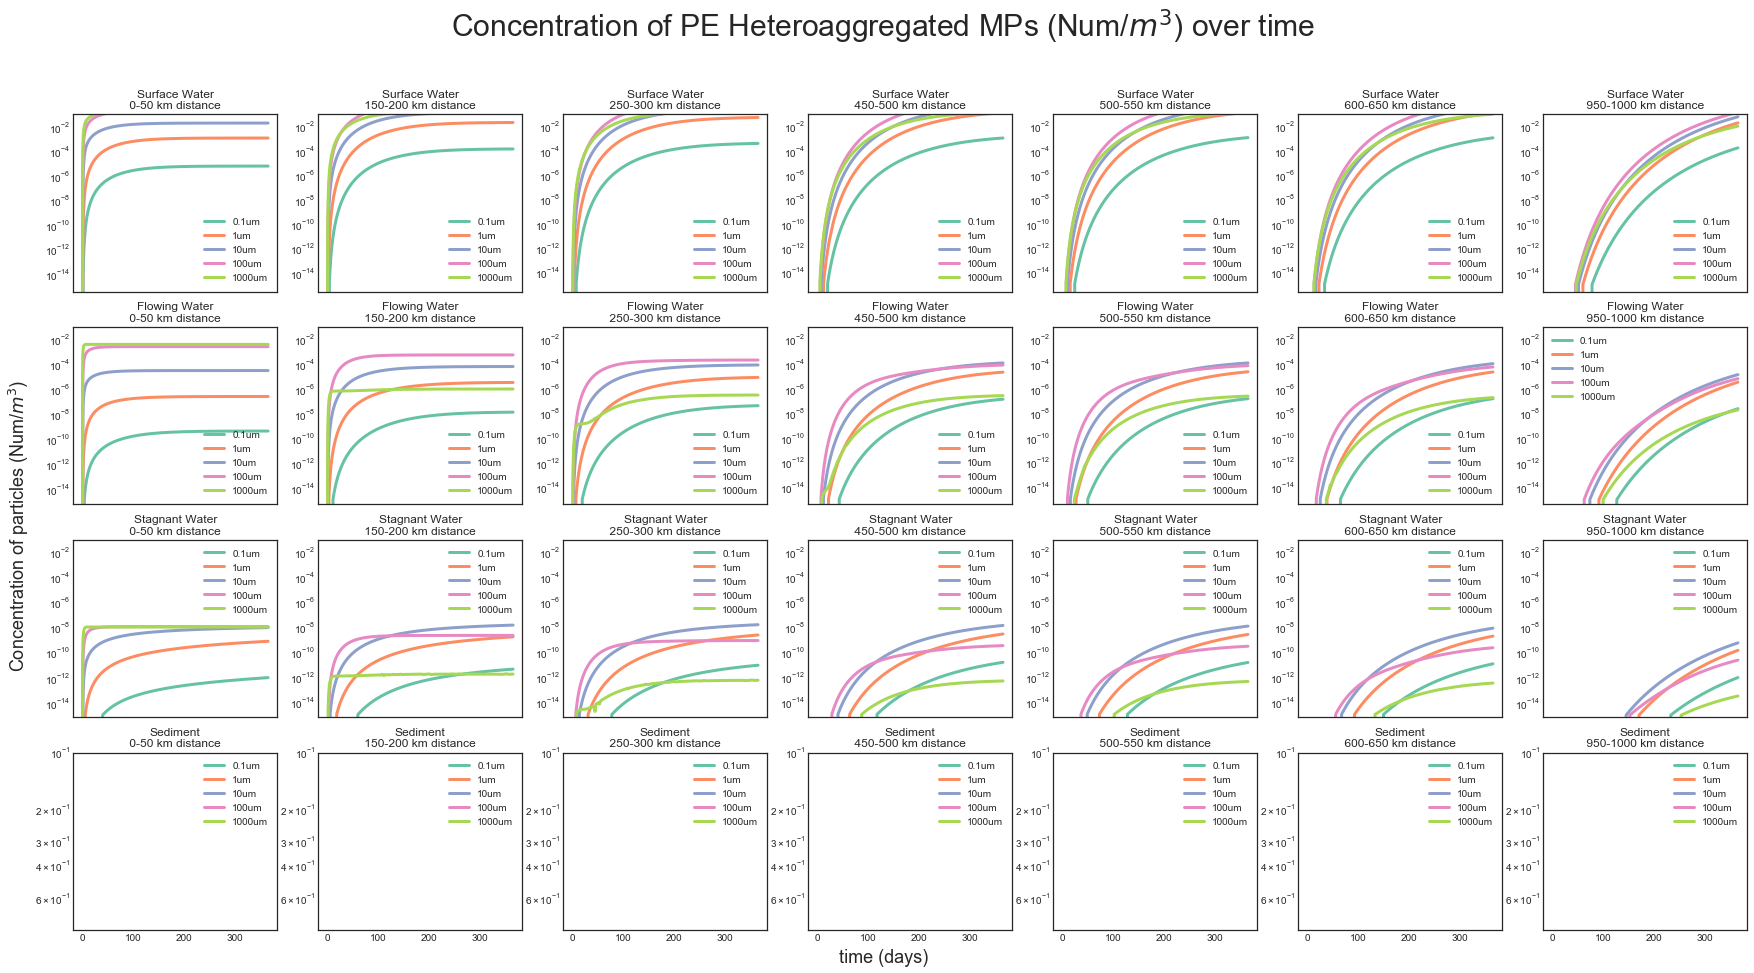

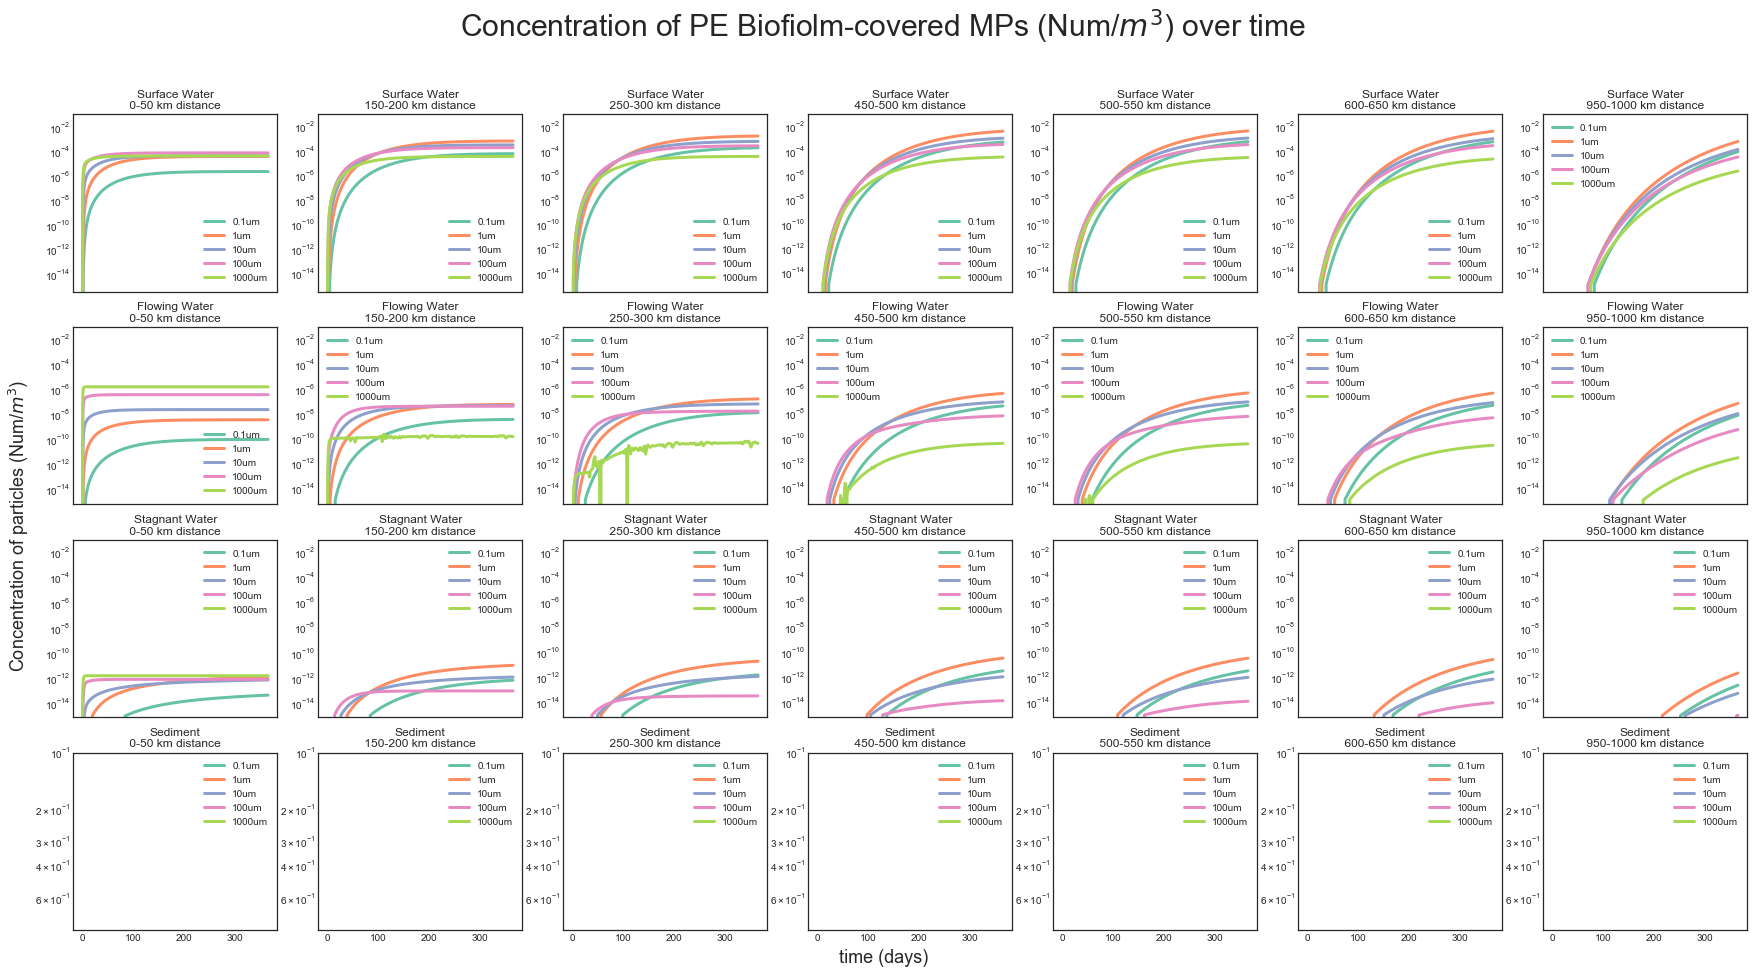

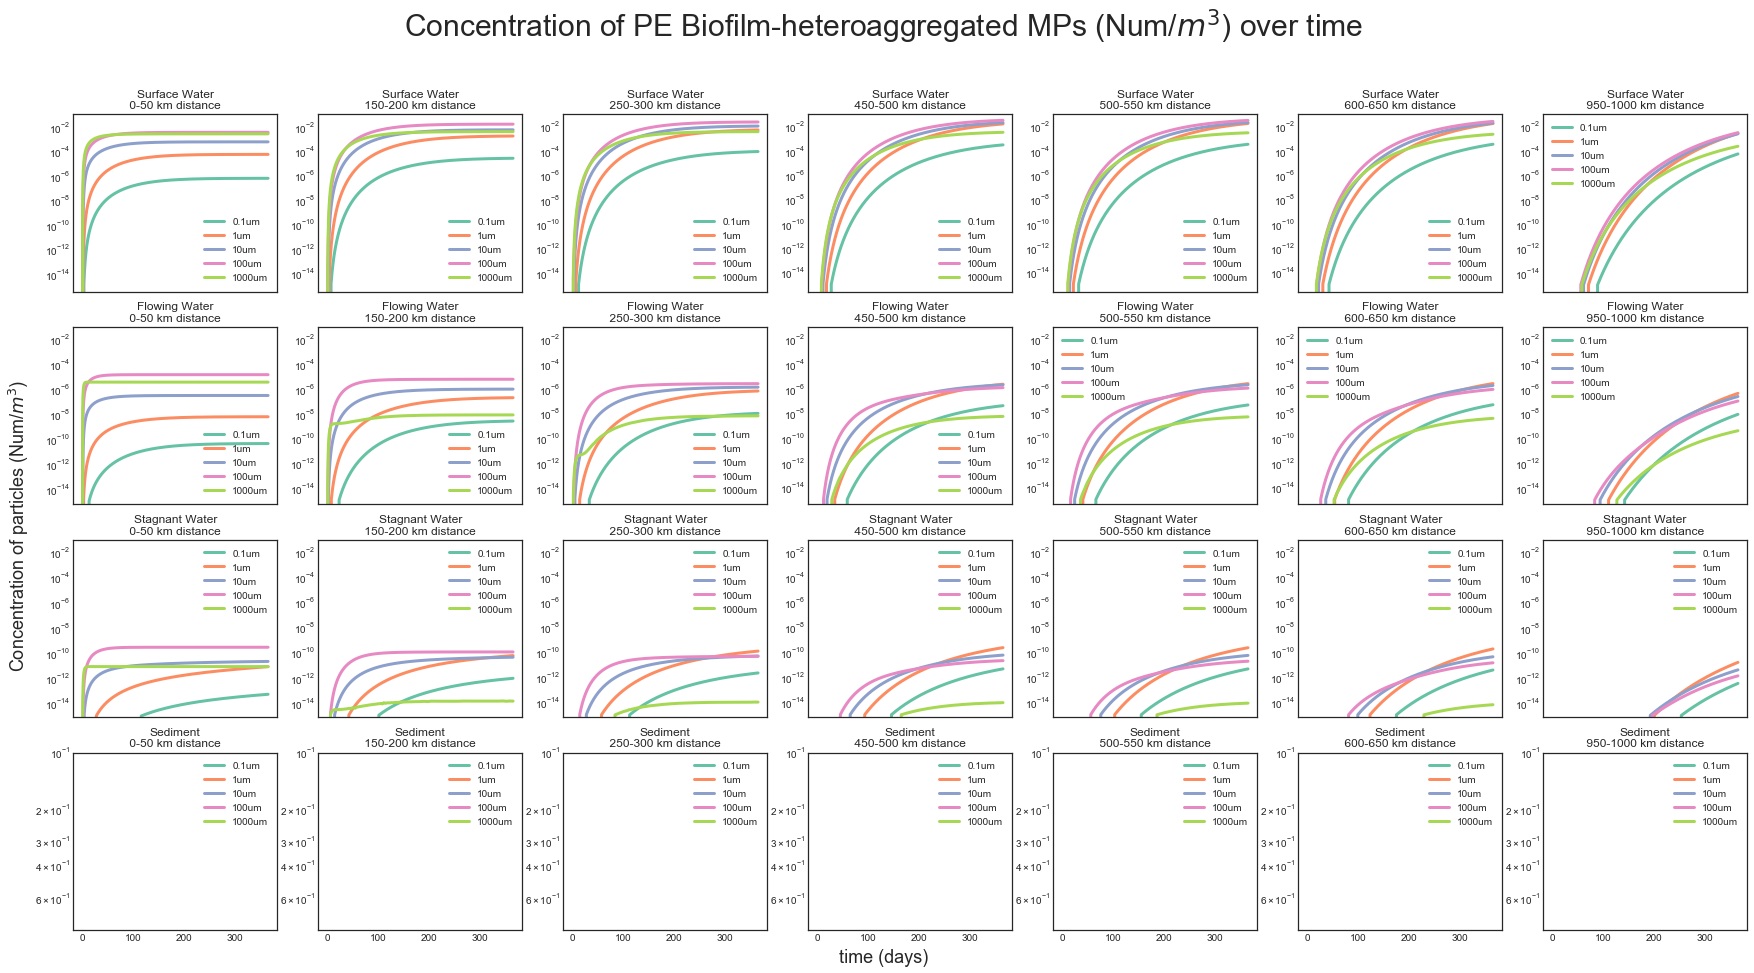

In [23]:
figures=[]
png_labels=[]
for p in range(len(MPforms)):
    fig, axs = plt.subplots(len(compartments),len(RS), figsize=(30, 15),sharex='col')
    fig.suptitle("Concentration of "+ composition +" " + MPformslabels[p]+ " MPs (Num/$m^3$) over time", fontsize=30)
    for i in range(len(RS)):
        for j in range(len(compartments)):
           for k in range(len(sizeBin)):

               axs[j,i].plot(t_span_days, ConcFinal_num_m3.loc[:,"C_"+RS[i]+str(j+1)+MPforms[p]+ sizeBin[k]], label= sizeBinLabel[k], color=palette(k), linewidth=3);
               axs[j,i].set_yscale("log")
               axs[j,i].set_ylim(0,1e-1)
               if RS[i] == "0":
                   axs[j,i].set_title(compartments[j]+"\n 0-" + str(int(RS_cumLength_m[int(RS[i])]/1000))+" km distance ", y=1.0)
               else:               
                   axs[j,i].set_title(compartments[j]+"\n "+str(int(RS_cumLength_m[int(RS[i])-1]/1000))+ "-" + str(int(RS_cumLength_m[int(RS[i])]/1000))+" km distance ", y=1.0)

               #axs[j,i].set_yscale('log')
               axs[j,i].legend()
               # if RS==6:
               #     axs[j,i].text(1.1, 0.5, compartments[j])   

    # Axis titles
    plt.text(0.1, 0.5, "Concentration of particles (Num/$m^3$)", fontsize=18, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
    plt.text(0.5, 0.1, "time (days)", fontsize=18, transform=plt.gcf().transFigure, ha='center', va='center')
    png_label = "Concentration_Num_m3_Multiplot_sizeBins_"+ MPformslabels[p] +"_" +composition+'.png'
    png_labels.append(png_label)
    figures.append(fig)

### Create Results and Figures folders

In [28]:
#####Set current working directory
cwd = os.getcwd()
cwd 

'C:\\Users\\PradoDomercq\\Documents\\GitHub\\Full-Multi_River_Model\\Full_Multi_Microplastics_River_Model_test'

In [29]:
os.chdir(cwd+"/Results")
    
#create folder for the day if it doesnt already exists

path = cwd+"/Results"
os.path.isdir(path)
old_path = (daterun_label)
new_path = os.path.isdir(old_path)
if not new_path:
    os.makedirs(old_path)
    print("Created Folder : ", old_path)
else:
    print(old_path, "folder already exists.")

results_path= cwd+"/Results/"+old_path

os.chdir(results_path)

Created Folder :  31_03_2021


In [30]:
os.chdir(results_path)
Fig_folder= "/Figures"
os.path.isdir(results_path+Fig_folder)

new_path = os.path.isdir(results_path+Fig_folder)
if not new_path:
    os.mkdir("Figures")
    print("Created Folder : ", Fig_folder)
else:
    print(Fig_folder, "folder already exists.")

results_figures_path= results_path+Fig_folder


Created Folder :  /Figures


### Save figure

In [31]:
os.chdir(results_figures_path)
for f in range(len(figures)):
    figg=figures[f]
    figg_name=png_labels[f]
    figg.savefig(figg_name)   

## Multyplots graphs: Concentration vs distance over time (GIF)

### - Organise results for dynamic plotting

#### Function to extract concentration values by size fraction

In [24]:
def extract_SizeBins (t, comp, MPform,):
    Aa=[]
    Ab=[]
    Ac=[]
    Ad=[]
    Ae=[]
    for i in range(len(listRS)):
        Aa.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"a")])
        Ab.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"b")])
        Ac.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"c")])
        Ad.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"d")]) 
        Ae.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"e")]) 
    return [Aa, Ab, Ac, Ad, Ae]

#### Function to extract lists from a list by criteria

In [25]:
def listofindex(criteria,Clist):                                                                                                             
    lista= [[] for x in range(len(criteria))]
    for i in range(len(lista)):
        lista[i] = [n for n in Clist if criteria[i] in n[-3:]]
    return lista

#### Extract list of indexes needed for plotting

In [26]:
list_of_indexesMpType=listofindex(MPforms,Clist)
list_of_indexesCompartments=listofindex(riverComp,Clist)
list_ofindexesSizeBins=listofindex(sizeBin,Clist)

#### Define time resolution for extracting results

In [27]:
numTstep_hour=(60/stepSize)
Time_months=t_span[::(int(numTstep_hour*24*30))]
Time_days=t_span[::(int(numTstep_hour*24))]
Time_halfMonth=t_span[::(int(numTstep_hour*24*15))]

In [28]:
time_extract=Time_months

#### Extract data for plotting

#### Set x values (distance in km)

In [29]:
#Distance values
x =[d/1000 for d in RS_cumLength_m]
compartmentsLabel=["Surface\n Water", "Flowing\n Water", "Stagnant\n Water", "Sediment"]

#### Dataframe of y values (num/m$^3$)

In [30]:
y_multiplot_time= [[] for t in range(len(time_extract))]
for t in range(len(time_extract)):
    y_multiplot =pd.DataFrame(index=compartments, columns=MPformslabels)
    #Estimate relative abundance of MP types in the whole river and of particles per compartment
    for j in range(len(compartments)):
            for k in range(len(MPforms)):
                y_multiplot.iloc[j,k] = extract_SizeBins(int(time_extract[t]/stepSize), str(j+1),MPforms[k])  
    y_multiplot_time[t]=y_multiplot               
y_multiplot_time            

[                                                             Free  \
 Surface Water   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Flowing Water   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Stagnant Water  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Sediment        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 
                                                  Heteroaggregated  \
 Surface Water   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Flowing Water   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Stagnant Water  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Sediment        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 
                                                  Biofiolm-covered  \
 Surface Water   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Flowing Water   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Stagnant Water  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
 Sediment       

#### Distribution of MPs per aggregation state and compartment over time 


In [31]:
MpTypeNum_t=pd.DataFrame(index=range(len(time_extract)),columns=["Timepoint (min)"]+[m+" (Total number)" for m in MPformslabels]+["Total"])
RelativeAbun_MPtype_t=pd.DataFrame(0, columns=["Timepoint (days)"]+[m+" (%)" for m in MPformslabels], index=MpTypeNum_t.index)
compNum_t=pd.DataFrame(index=range(len(time_extract)),columns=["Timepoint (min)"]+[m+" (Total number)" for m in compartments])
RelativeAbun_Comp=pd.DataFrame(0, columns=["Timepoint (days)"]+[m+" (%)" for m in compartments], index=MpTypeNum_t.index)
for t in range(len(time_extract)):
    #Convert concentration to particle number
    PartNum_timestep=ConcFinal_num_m3.iloc[int(time_extract[t]/stepSize)]*dilution_vol_m3
    MpTypeNum_t.iloc[t,len(MPforms)+1]=sum(PartNum_timestep)
    PartNum_timestep=PartNum_timestep.to_frame()
    for mp in range(1,1+len(MPforms)):
        MpTypeNum_t.iloc[t,mp]=sum(PartNum_timestep.loc[list_of_indexesMpType[mp-1], :][time_extract[t]].to_list())
        if MpTypeNum_t.iloc[t,len(MPforms)+1] == 0:
            RelativeAbun_MPtype_t.iloc[t,mp]= 0
        else:
            RelativeAbun_MPtype_t.iloc[t,mp]=round((MpTypeNum_t.iloc[t,mp]/MpTypeNum_t.iloc[t,len(MPforms)+1])*100,2)
    for com in range(1,1+len(compartments)):
        compNum_t.iloc[t,com]=sum(PartNum_timestep.loc[list_of_indexesCompartments[com-1], :][time_extract[t]].to_list())
        if MpTypeNum_t.iloc[t,len(MPforms)+1]== 0:
            RelativeAbun_Comp.iloc[t,com]=0
        else:
            RelativeAbun_Comp.iloc[t,com]=round((compNum_t.iloc[t,com]/MpTypeNum_t.iloc[t,len(MPforms)+1])*100,2)
    RelativeAbun_MPtype_t.iloc[t,0]=int((time_extract[t]/stepSize)/24)
    MpTypeNum_t.iloc[t,0]=time_extract[t]/stepSize
    compNum_t.iloc[t,0]=time_extract[t]/stepSize
    RelativeAbun_Comp.iloc[t,0]=int((time_extract[t]/stepSize)/24)

#### - Relative abundance of MPs aggregation states in the whole system per time step

In [32]:
MpTypeNum_t

,Timepoint (min),Free (Total number),Heteroaggregated (Total number),Biofiolm-covered (Total number),Biofilm-heteroaggregated (Total number),Total
0,0,0,0,0,0,0
1,720,129036,294045,94.9559,2352.12,425529
2,1440,173669,576989,206.461,7573.67,758438
3,2160,242398,955597,425.645,15499.9,1.21392e+06
4,2880,342681,1.44906e+06,825.3,26597.9,1.81917e+06
5,3600,481409,2.0708e+06,1499.02,41435.1,2.59514e+06
6,4320,665265,2.83212e+06,2560.82,60684,3.56063e+06
7,5040,900850,3.74377e+06,4144.45,85155.5,4.73392e+06
8,5760,1.19466e+06,4.81616e+06,6401.98,115818,6.13304e+06
9,6480,1.5528e+06,6.05874e+06,9500.1,153783,7.77483e+06


In [33]:
RelativeAbun_MPtype_t

,Timepoint (days),Free (%),Heteroaggregated (%),Biofiolm-covered (%),Biofilm-heteroaggregated (%)
0,0,0.00,0.00,0.00,0.00
1,30,30.32,69.10,0.02,0.55
2,60,22.90,76.08,0.03,1.00
3,90,19.97,78.72,0.04,1.28
4,120,18.84,79.66,0.05,1.46
5,150,18.55,79.80,0.06,1.60
6,180,18.68,79.54,0.07,1.70
7,210,19.03,79.08,0.09,1.80
8,240,19.48,78.53,0.10,1.89
9,270,19.97,77.93,0.12,1.98


#### - Fractionation of MPs per compartmet over time for the whole system

In [34]:
RelativeAbun_Comp

,Timepoint (days),Surface Water (%),Flowing Water (%),Stagnant Water (%),Sediment (%)
0,0,0.00,0.00,0.0,0.0
1,30,37.61,62.39,0.0,0.0
2,60,59.92,40.08,0.0,0.0
3,90,73.49,26.51,0.0,0.0
4,120,81.78,18.22,0.0,0.0
5,150,86.98,13.02,0.0,0.0
6,180,90.35,9.65,0.0,0.0
7,210,92.61,7.39,0.0,0.0
8,240,94.18,5.82,0.0,0.0
9,270,95.30,4.70,0.0,0.0


#### Choose style and colour palette

In [35]:
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-white')
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='ivory', alpha=0.5)
props2 = dict(boxstyle='round', facecolor='white', alpha=0.5)

### PLOT

### Single plot: Concentration vs distance over time

#### Select Compartment and MP aggregation state to plot
#### Compartmets: 
- Surface Water = 0
- Flowing Water = 1
- Stagnant Water = 2
- Sediment = 3

#### MP aggregation state: 
- Free = 0 
- Heteroaggregated = 1
- Biofiolm-covered = 2
- Biofilm-heteroaggregated = 3 

In [36]:
aggSt=2

#### Dynamic plot

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


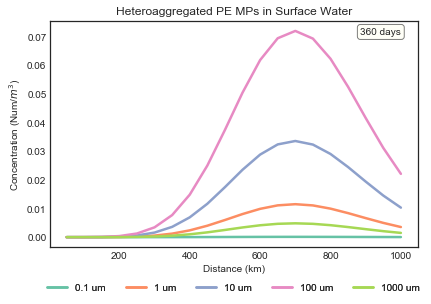

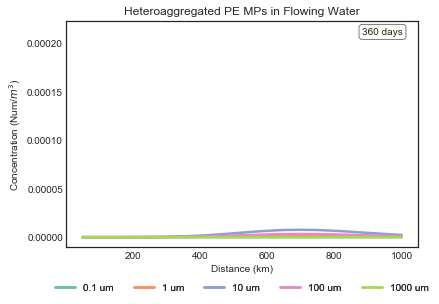

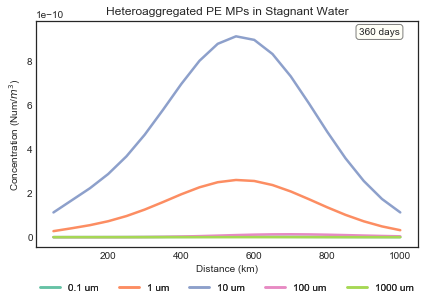

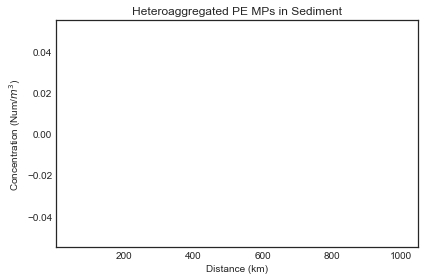

In [42]:
os.chdir(results_figures_path)
for compart in range(len(compartments)):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Concentration (Num/$m^3$)")
    ax.set_title(MPformslabels[aggSt]+ " " + composition+ " MPs in "+ compartments[compart])
    ax.set_yscale('log')
    ax.set_ylim(1e-13,1e1)
    labels = ['0.1 um', '1 um', '10 um', '100 um', '1000 um']
    ax.legend(labels, loc='best')

    camera = Camera(fig)
    for t in range(len(time_extract)):
        y = y_multiplot_time[t].iloc[compart,aggSt]
        ax.plot(x, y[0], linewidth=2.5,color=palette(0), label='0.1 um')
        ax.plot(x, y[1], linewidth=2.5,color=palette(1), label='1 um')
        ax.plot(x, y[2], linewidth=2.5,color=palette(2), label='10 um')
        ax.plot(x, y[3], linewidth=2.5,color=palette(3), label='100 um')
        ax.plot(x, y[4], linewidth=2.5,color=palette(4), label='1000 um')
        ax.text(0.90,0.95,str(int(time_extract[t]/60/24)) + ' days', bbox=props, transform=ax.transAxes, ha='center', va='center')
        ax.legend(labels,bbox_to_anchor=(0.5, -0.18), loc='center',ncol=5 )
        camera.snap()

    plt.tight_layout()
    animationTitle=MPformslabels[aggSt]+ "_" + composition+ "_MPs_in_"+ compartments[compart]+".gif"
    animation = camera.animate()
    animation.save(animationTitle, writer='matplotlib.animation.PillowWriter', fps=2)


### Multiplot: Concentration vs distance over time

#### Dynamic plot

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


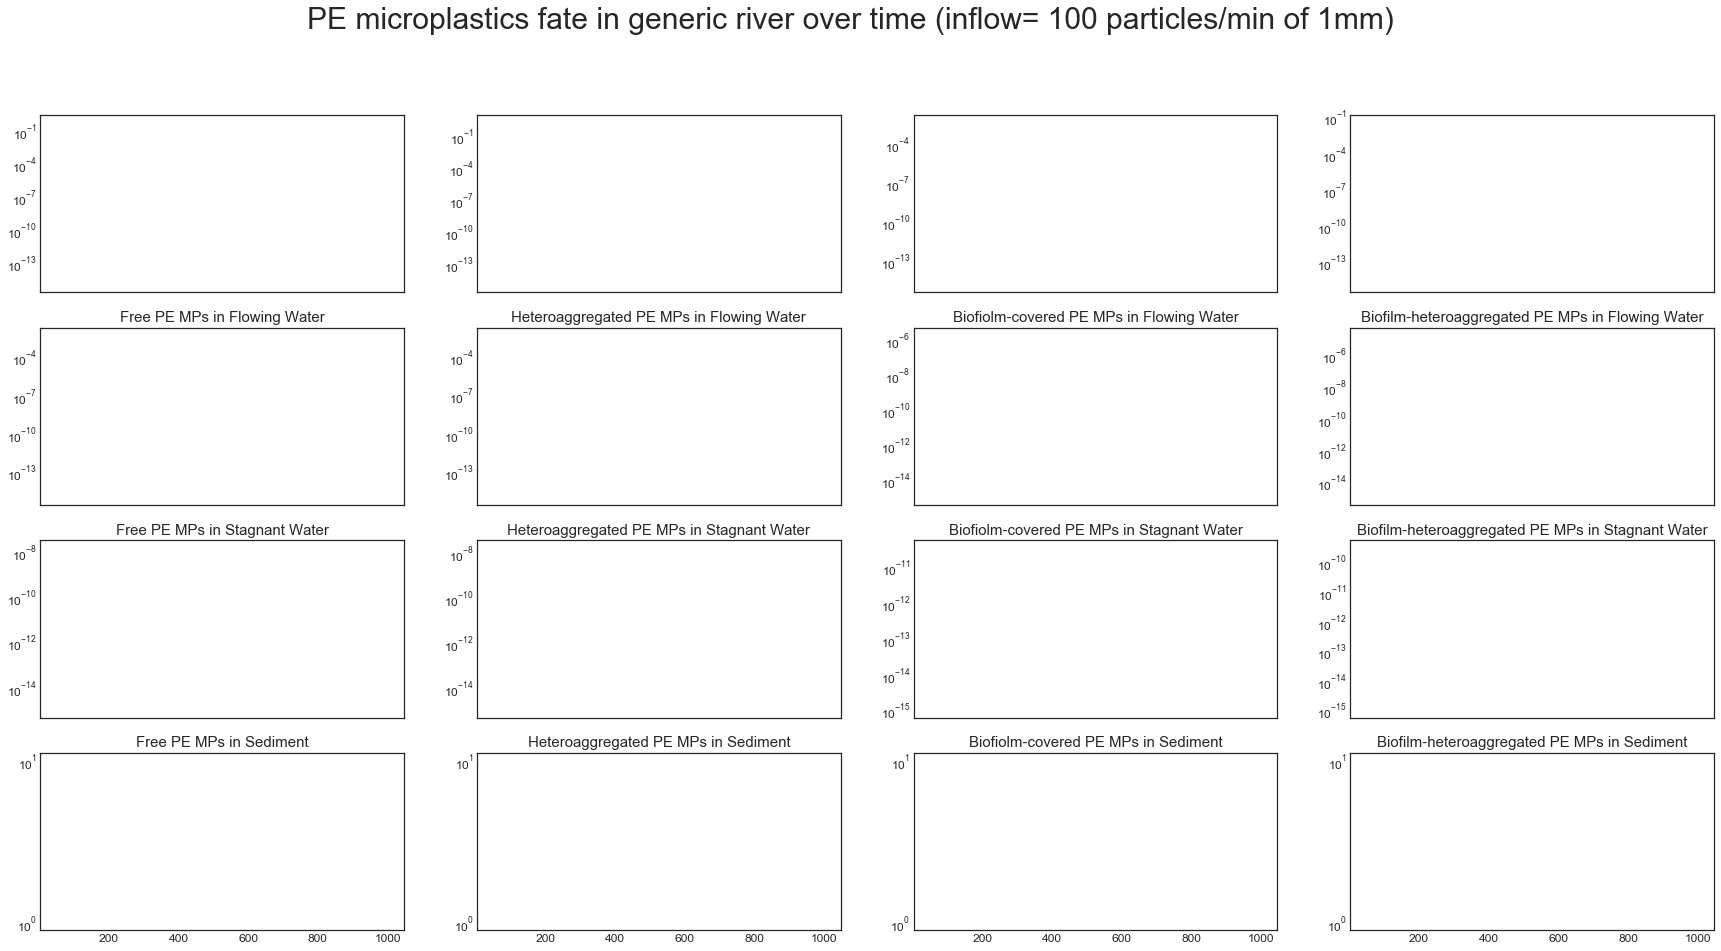

In [44]:
fig, axs = plt.subplots(len(compartments),len(MPforms), figsize=(30, 15),sharex='col')
labels = ['0.1 um', '1 um', '10 um', '100 um', '1000 um']
if imputFlow == 0:
    fig.suptitle( composition +" microplastics fate in generic river over time (pulse= "+ str(imputPulse)+" particles of 1mm)", fontsize=30)
else:
    fig.suptitle( composition +" microplastics fate in generic river over time (inflow= "+str(imputFlow)+" particles/min of 1mm)", fontsize=30)
camera = Camera(fig)
for t in range(len(time_extract)): 
    for j in range(len(compartments)):
        for k in range(len(MPforms)):
            #Plot
            y = y_multiplot_time[t].iloc[j,k]
            axs[j,k].plot(x, y[0], linewidth=2.5,color=palette(0), label='0.1 um')
            axs[j,k].plot(x, y[1], linewidth=2.5,color=palette(1), label='1 um')
            axs[j,k].plot(x, y[2], linewidth=2.5,color=palette(2), label='10 um')
            axs[j,k].plot(x, y[3], linewidth=2.5,color=palette(3), label='100 um')
            axs[j,k].plot(x, y[4], linewidth=2.5,color=palette(4), label='1000 um')
            axs[j,k].text(0.90,0.90,str(int(Time_months[t]/60/24)) + ' days', bbox=props, fontsize=12, transform=axs[j,k].transAxes, ha='center', va='center')
            #Set axes labels and title
            if j== 0:
                axs[j,k].text(0.5,1.1, MPformslabels[k]+ "\n " +str(RelativeAbun_MPtype_t.iloc[t,k+1])+ " %",fontsize=20, bbox=props2, transform= axs[j,k].transAxes, ha='center')        
            else:
                axs[j,k].set_title(MPformslabels[k]+ " " + composition+ " MPs in "+ compartments[j],fontsize=15)
      
            if k==0:
                axs[j,k].text(-0.25, 0.5, compartmentsLabel[j]+"\n"+str(RelativeAbun_Comp.iloc[t,j+1])+" %",fontsize=20,rotation=0, va='center',ha='center',bbox=props2, transform=axs[j,k].transAxes)
                
        
            axs[j,k].set_yscale('log')
            #if j==0:
                #axs[j,k].set_ylim(0,1.5)
            #elif j==1:
                #axs[j,k].set_ylim(0,0.004)
            #elif j== 2:
               # axs[j,k].set_ylim(-0.04,0.04)
            #else:
                #axs[j,k].set_ylim(-0.04,0.04)
            #axs[j,k].set_xlim(x[0],x[-1])
            axs[j,k].tick_params(axis='x', labelsize=12)
            axs[j,k].tick_params(axis='y', labelsize=12)
           
    # Axis titles
    plt.text(0.05, 0.5, "Concentration of particles (Num/$m^3$)", fontsize=20, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
    plt.text(0.5, 0.08, "Distance (km)", fontsize=20, transform=plt.gcf().transFigure, ha='center', va='center')
    #plt.legend(labels,bbox_to_anchor=(0.5, -0.18), loc='center',ncol=5, fontsize=15 )
    camera.snap()
           
            
animationTitle= composition+ "_MPs_fate_dynamicPlot_log.gif"
animation = camera.animate()
animation.save(animationTitle, writer='matplotlib.animation.PillowWriter', fps=2) 

# Save results

In [47]:
if record == "True":   
    os.chdir(cwd+"/Results")
    
    #create folder for the day if it doesnt already exists
    path = cwd+"/Results"
    os.path.isdir(path)
    old_path = (daterun_label)
    new_path = os.path.isdir(old_path)
    if not new_path:
        os.makedirs(old_path)
        print("Created Folder : ", old_path)
    else:
        print(old_path, "folder already exists.")
    
    results_path= cwd+"/Results/"+old_path
    
    os.chdir(results_path)
    #save
    #rate constants 
    dfRC_filename = "RC_df" + runtitle +"_"+ daterun_label + ".csv"
    RC_df_templim.to_csv(dfRC_filename)
    
    #interactions dataframe to results folder
    interactions_filename = "interactionsdf_"+ runtitle +"_"+  daterun_label + ".csv"
    interactions_df.to_csv(interactions_filename)
    
    #Results
    filename= "ConcVStime_particleNum_m3"+ runtitle +"_"+ daterun_label+".csv"
    filename1= "MassVStime_kg"+ runtitle +"_"+ daterun_label+".csv"
    ConcFinal_num_m3.to_csv(filename)
    ConcFinal_kg_m3.to_csv(filename1)
    RelativeAbun_MPtype_t.to_csv("Relative_abundance_MPtype_"+composition+daterun_label+".csv")  
    RelativeAbun_Comp.to_csv("Relative_abundance_Compartment_"+composition+daterun_label+".csv")  
    

    #back to working directory
    os.chdir(cwd)
    

06_04_2021 folder already exists.
